## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

import sklearn.model_selection as skl
from itertools import chain
from skimage import io
from sklearn.metrics import roc_curve, auc, precision_recall_curve   

from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model

from keras.optimizers import Adam

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
30221,00007880_003.png,No Finding,3,7880,57,M,AP,2500,2048,0.168,0.168,NaN,data/images_004/images/00007880_003.png
31459,00008229_000.png,No Finding,0,8229,51,F,PA,2544,3056,0.139,0.139,NaN,data/images_004/images/00008229_000.png
106401,00028660_000.png,No Finding,0,28660,25,M,PA,3056,2544,0.139,0.139,NaN,data/images_012/images/00028660_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)

all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
39638,00010357_002.png,Atelectasis|Mass,2,10357,46,F,AP,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,0
9322,00002428_001.png,No Finding,1,2428,66,F,PA,2048,2500,0.171,...,0,0,0,0,0,1,0,0,0,0
75446,00018518_001.png,No Finding,1,18518,49,F,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo

all_xray_df['pneumonia_class'] = np.where( all_xray_df.Pneumonia == 1, "positive",  "negative")

## Create your training and testing data:

In [5]:
def create_splits(dataset):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    train_data, val_data = skl.train_test_split(dataset, 
                                   test_size = 0.2, 
                                   stratify = dataset['Pneumonia'])
    
    return train_data, val_data



In [6]:
train_data, val_data = create_splits(all_xray_df)

train_data['Pneumonia'].sum()/len(train_data)

0.012765340706386016

In [7]:
val_data['Pneumonia'].sum()/len(val_data)

0.012754191937210132

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
IMG_SIZE = (224, 224)

In [9]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    
    
    idg = ImageDataGenerator( rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return idg


def make_train_gen(train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    
    idg = my_image_augmentation()
    
    
    train_gen = idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 16)
    
    return train_gen


def make_val_gen(valid_df):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    

    
    val_idg = ImageDataGenerator(rescale=1. / 255.0)

    
    val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = "binary",
                                         target_size = IMG_SIZE, 
                                         batch_size = 32)
    return val_gen

In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data)


valX, valY = val_gen.next()

Found 22424 validated image filenames belonging to 2 classes.


In [11]:
## May want to pull a single large batch of random validation data for testing after each epoch:
train_gen = make_train_gen(train_data)


trainX, trainY = train_gen.next()

Found 89696 validated image filenames belonging to 2 classes.


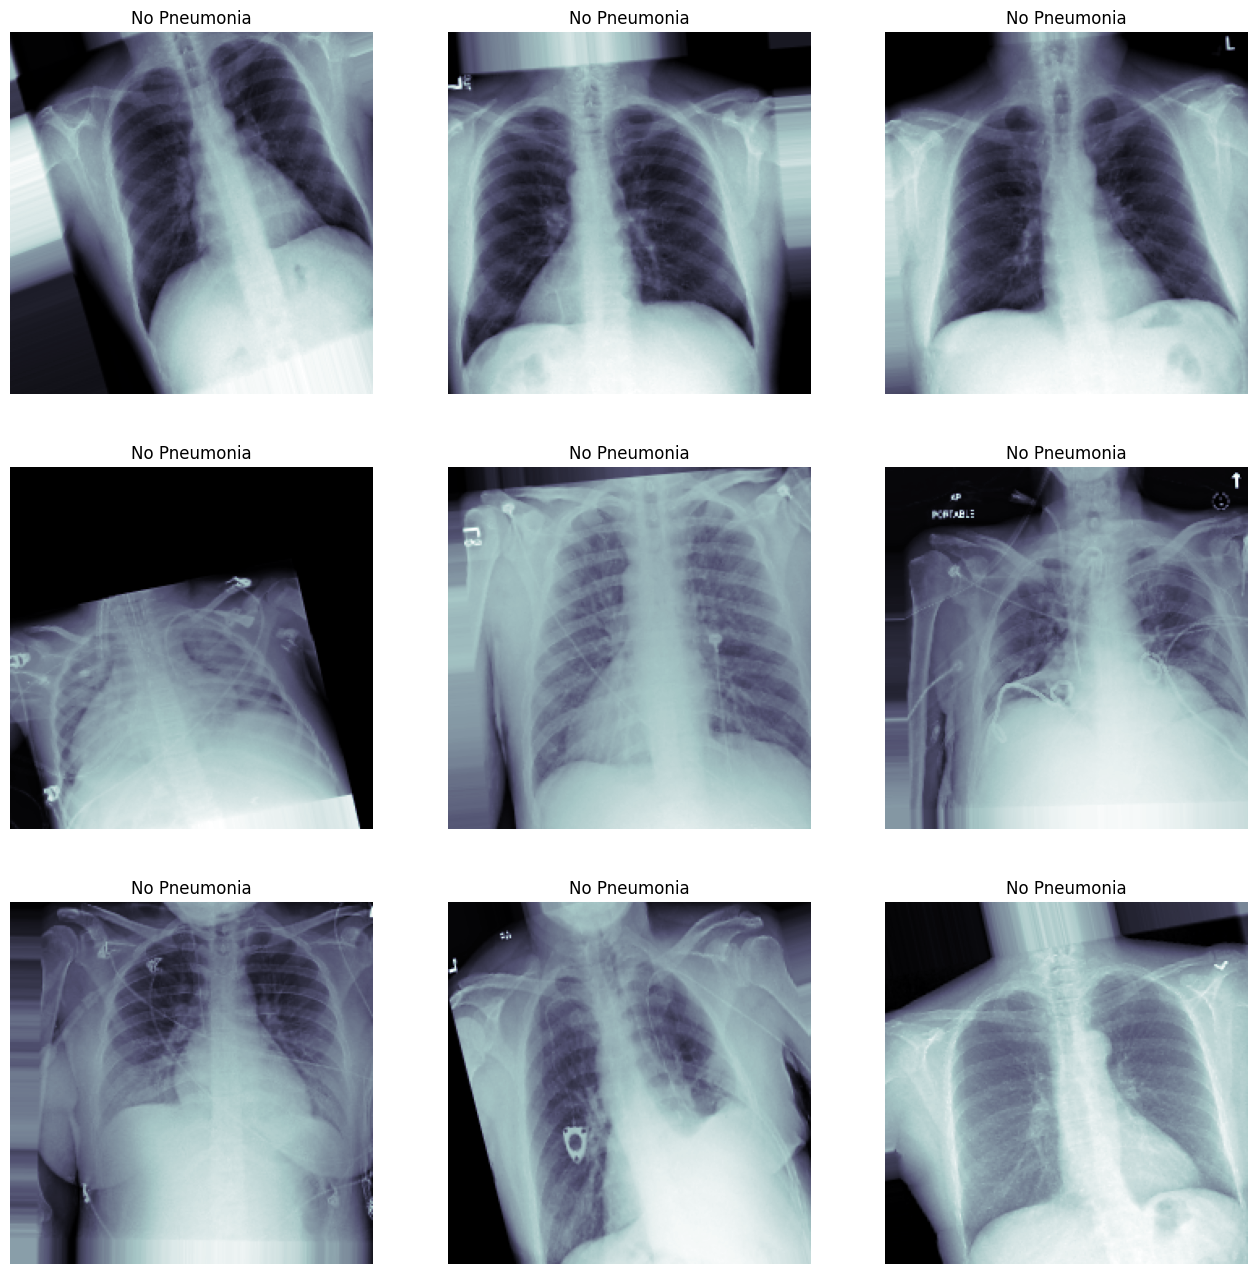

In [12]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [13]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    
    vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
    
    for layer in vgg_model.layers:        
        print(layer.name, layer.trainable)
        
    return vgg_model


In [14]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))
    
    
    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results


In [15]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "val_loss", # test with [''] 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= "val_loss", 
                      mode= 'auto', 
                      patience=6)

callbacks_list = [checkpoint, early]

### Start training! 

In [16]:
vgg_model = load_pretrained_model()

new_model = build_my_model(vgg_model)

2022-12-27 06:53:03.360491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 06:53:03.392006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 06:53:03.392492: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 06:53:03.393192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [17]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(learning_rate=1e-3)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [18]:
## train your model

# Todo


history = new_model.fit(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10


2022-12-27 06:53:07.390417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-27 06:53:08.339255: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


5606/5606 [==============================] - ETA: 0s - loss: 0.1072 - binary_accuracy: 0.9870
Epoch 1: val_loss improved from inf to 0.13696, saving model to xray_class_my_model.best.hdf5
5606/5606 [==============================] - 1420s 252ms/step - loss: 0.1072 - binary_accuracy: 0.9870 - val_loss: 0.1370 - val_binary_accuracy: 0.9688
Epoch 2/10
5606/5606 [==============================] - ETA: 0s - loss: 0.0881 - binary_accuracy: 0.9871
Epoch 2: val_loss did not improve from 0.13696
5606/5606 [==============================] - 1412s 252ms/step - loss: 0.0881 - binary_accuracy: 0.9871 - val_loss: 1.8425 - val_binary_accuracy: 0.9688
Epoch 3/10
5606/5606 [==============================] - ETA: 0s - loss: 0.0961 - binary_accuracy: 0.9870
Epoch 3: val_loss did not improve from 0.13696
5606/5606 [==============================] - 1385s 247ms/step - loss: 0.0961 - binary_accuracy: 0.9870 - val_loss: 0.1488 - val_binary_accuracy: 0.9688
Epoch 4/10
5606/5606 [==============================

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [58]:
pred_Y

array([[0.0456527 ],
       [0.05002718],
       [0.06408633],
       ...,
       [0.04226436],
       [0.04204806],
       [0.04634761]], dtype=float32)

In [67]:
val_data['Pneumonia'].values

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
new_model.

(32,)

In [47]:
valX.shape

(32, 224, 224, 3)

In [49]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
new_model.load_weights(weight_path)
pred_Y = new_model.predict(val_gen, batch_size = 64, verbose = True)

701/701 [==============================] - 228s 325ms/step


In [70]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return

    
#Also consider plotting the history of your model training:

# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    return

def plot_precision_recall_curve(t_y, p_y):
    precision, recall, threshold = precision_recall_curve(t_y,p_y,pos_label = 1)
    threshold = np.append(threshold, 1)
    plt.style.use('ggplot')
    plt.plot(precision, recall)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.show()
    
    return precision, recall, threshold

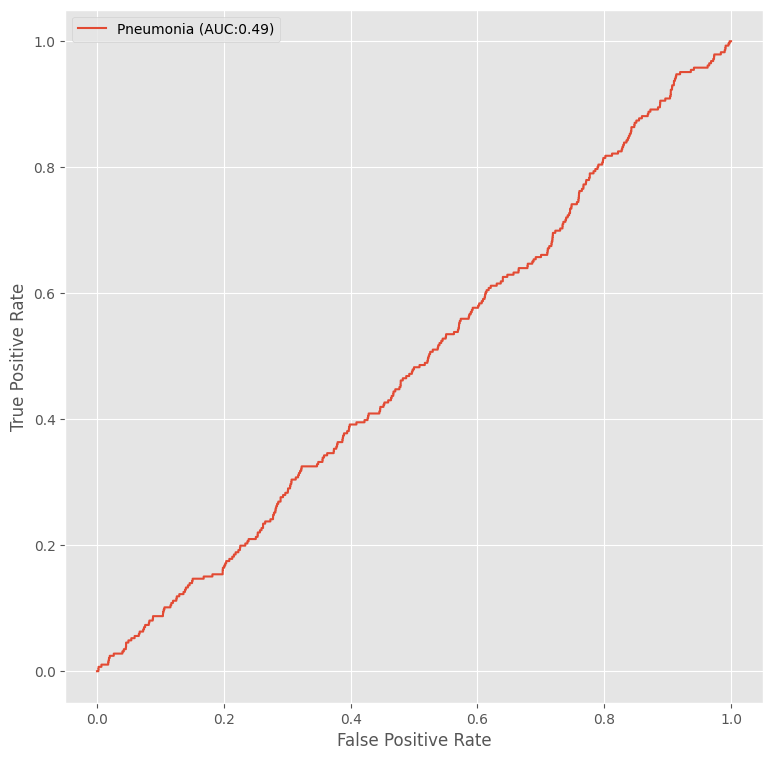

In [71]:
plot_auc(val_data['Pneumonia'].values, pred_Y)

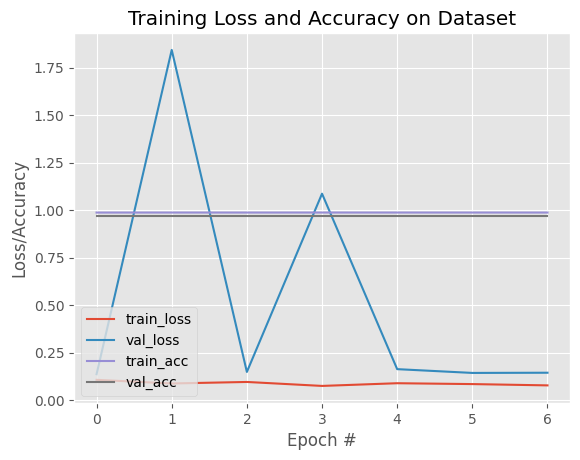

In [72]:
## plot figures
plot_history(history)
# Todo

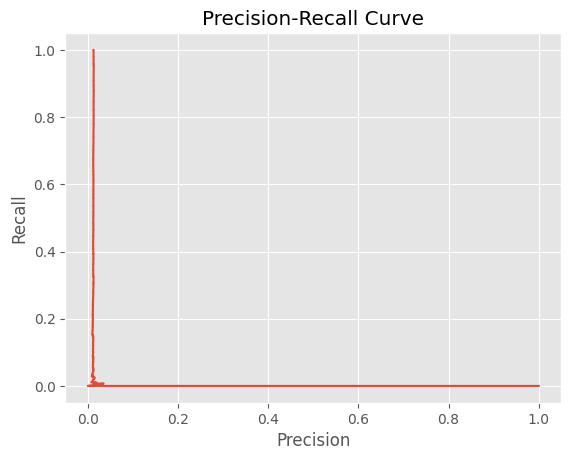

(array([0.01275419, 0.01275476, 0.01275533, ..., 0.        , 0.        ,
        1.        ]),
 array([1., 1., 1., ..., 0., 0., 0.]),
 array([0.00332725, 0.00562582, 0.0064179 , ..., 0.08224597, 0.08544968,
        1.        ]))

In [73]:
plot_precision_recall_curve(val_data['Pneumonia'].values, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [74]:
val_data.shape

(22424, 29)

In [79]:
valX.shape

(32, 224, 224, 3)

In [81]:
val_gen.

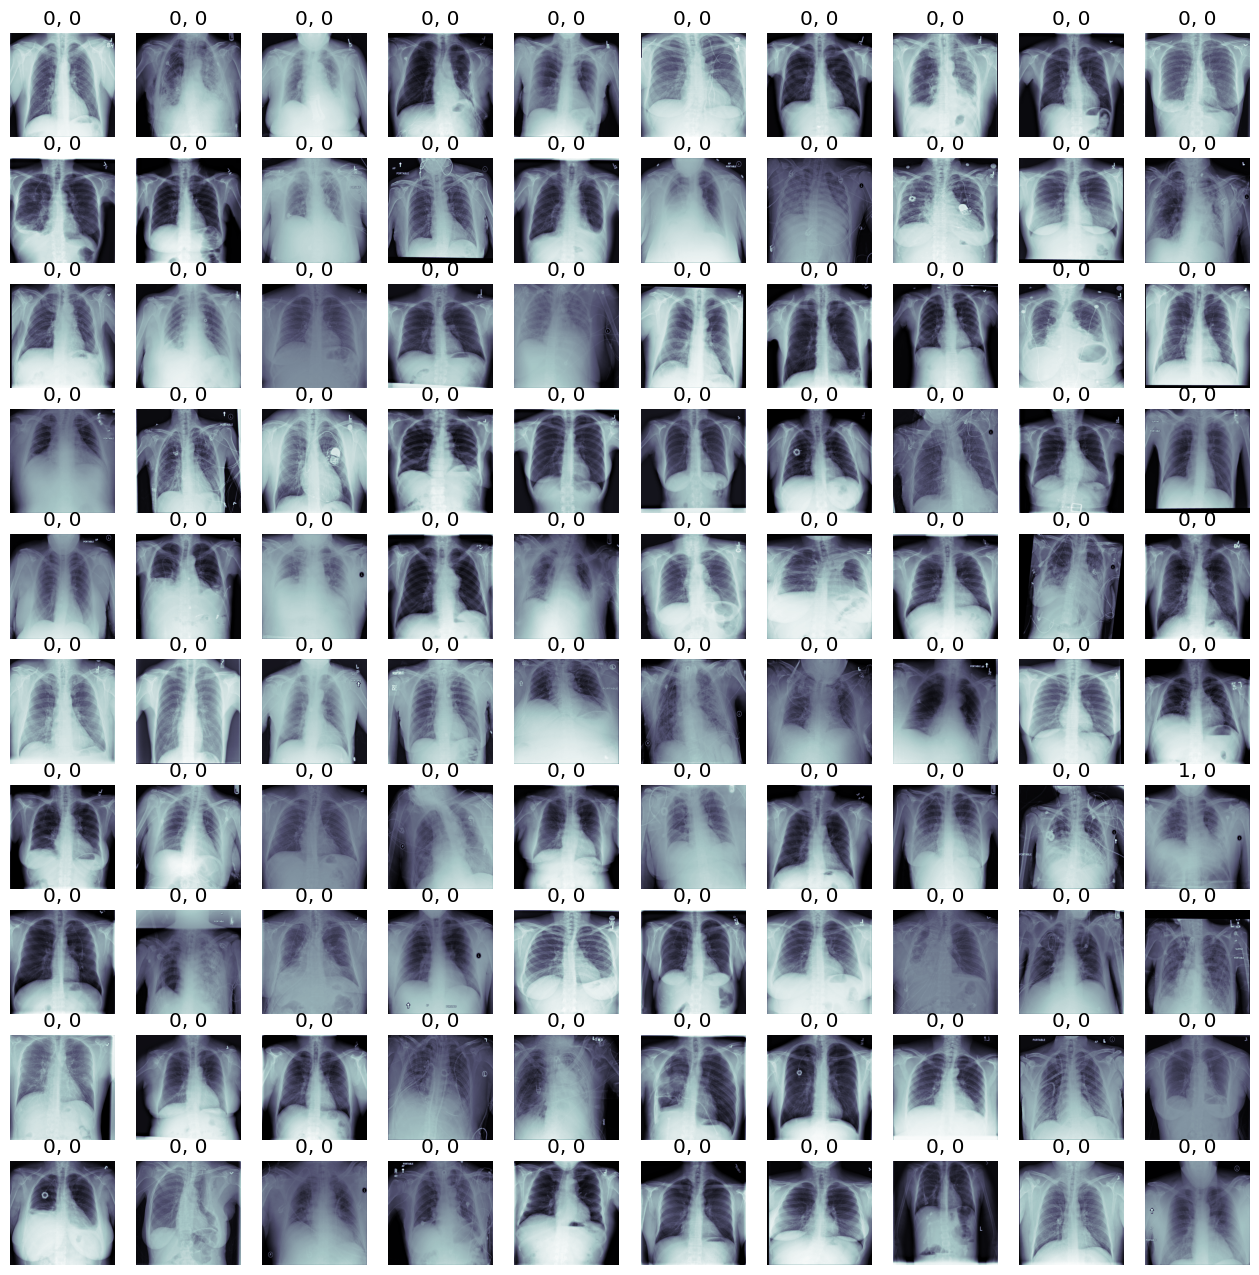

In [87]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
YOUR_THRESHOLD = 0.2

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0


for (c_x, c_y, c_ax) in zip(val_filenames[0:100], val_labels[0:100], m_axs.flatten()):
    c_ax.imshow(io.imread(c_x), cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = new_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)